In [ ]:
# устанавливаем необходимые зависимости

!pip3 install deeppavlov==0.15.0
!pip3 install fuzzywuzzy==0.18.0
!pip3 install langdetect
!pip3 install razdel
!pip3 install sklearn==0.24.2
!pip3 install pathlib
!pip3 install sacremoses==0.0.35
!pip3 install numpy==1.21.6
!pip3 install pandas==0.25.3
!pip3 install matplotlib==3.1.2
!pip3 install transliterate==1.10.2
!pip3 install fasttext==0.9.2

In [66]:
import sys
# указываем где искать вспомогательные модули
sys.path.insert(0, '../src')

import re

from pathlib import Path

from fuzzywuzzy import process  ##

import numpy as np
import pandas as pd

from deeppavlov.models.tokenizers.nltk_moses_tokenizer import NLTKMosesTokenizer
from transliterate import translit, get_available_language_codes
from razdel import sentenize, tokenize
from langdetect import detect
import fasttext
import fasttext.util

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

from matplotlib import pyplot as plt
import seaborn as sns

from gdrive_download import YDrive

## Скачиваем данные

In [2]:
# Инициализируем пути до данных
raw_fn = 'train.xlsx'
data_dir = Path.cwd().parent / 'data' / 'raw'

In [5]:
data_dir / raw_fn

PosixPath('/home/ewp/DEV/itmo_dublicate_detection/data/raw/train.xlsx')

In [3]:
# Скачиваем данные с Яндекс диска
link = 'https://disk.yandex.ru/d/eK15uq89IOUgfg'

yd = YDrive(link)
yd.download_from_yandex(destination=data_dir / raw_fn)

Файл скачан: /home/ewp/DEV/itmo_dublicate_detection/data/raw/train.xlsx


In [4]:
# считываем выборку в датафрэм
df_raw = pd.read_excel(data_dir.joinpath(raw_fn), engine='openpyxl')[['name_1', 'name_2', 'is_duplicate']]

In [17]:
# Описываем класс для работы со строками

# Нам понадобится функционал очистки от лишник пробелов и правильной расстановки точек

class FuzzyCompare:
    '''
    Методы обрадотки и сравнения строк
    '''

    def __init__(self):
        
        # инициализируем детокинайзер
        self.detokenizer = NLTKMosesTokenizer('en').detokenizer
        
    def norm_ref_items(self, txt):
        """
        Нормализация строки из датасета: приводим заники препинани к правильной структуре
        :param txt: исходная строка
        :return: преобразованная строка
        """
        if detect(txt) == 'ru':
            # производим транслитерацию на латиницу
            txt = translit(txt, language_code='ru', reversed=True)
        
        # расстановка пробелов и знаков препинания поправилам аббривеатур и разделителей
        tokens = self.detokenizer.detokenize([' '.join([_.text for _ in tokenize(txt)])])
        return ''.join(tokens).strip()
    
    def estimate(self, txt_1, txt_2, normalize=True):
        '''
        Подсчет меры близости двух строк
        :param txt_1: строка 1
        :param txt_2: строка 2
        :return: значение меры близости в пронтах
        '''
        if normalize:
            _txt_1 = self.norm_ref_items(txt_1)
            _txt_2 = self.norm_ref_items(txt_2)
        return process.extract(_txt_1, [_txt_2], scorer=fuzz.token_sort_ratio)[0][-1]
    
    def estimate_df(self, txt_tuple, normalize=True):
        '''
        Запуск сравнения для дадафрэйма: разбиваем значение по разделителю и производим сравнение
        '''
        t1, t2 = txt_tuple.split('|')
        return self.estimate(t1, t2)

## Подготовка модели вкторизации

In [6]:
# скачиваем модель и подгружаем для дальнейшей работы
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

In [7]:
# уменьшаем размерность вектора до 100 дляускорения
fasttext.util.reduce_model(ft, 100)
ft.get_dimension()

100

In [8]:
# получаем вектор для слова
ft.get_word_vector('N')

array([-1.3423371 , -0.06377444,  0.80848813,  0.38898322, -0.9335467 ,
        0.3239719 , -0.32535487,  0.43198904, -0.14691485,  0.43278474,
       -0.26213866, -0.42123833, -0.17760985,  0.06261823,  0.16315682,
        0.24314526,  0.23906992,  0.07467201, -0.1938648 ,  0.12235634,
       -0.12569393, -0.16006988, -0.527254  ,  0.66922957, -0.48276708,
        0.340102  ,  0.1499745 ,  0.40834123,  0.02817571,  0.25052282,
        0.5991975 ,  0.5636024 ,  0.13819523,  0.2787298 , -0.1653578 ,
       -0.33072475, -0.07503559, -0.00359884,  0.07588514,  0.03482349,
       -0.24260679, -0.20078157, -0.19642195,  0.0559804 , -0.18354866,
       -0.01606591,  0.13211118,  0.01120929, -0.04632983, -0.09561919,
       -0.20827085, -0.24839209,  0.06362022, -0.14107862,  0.00407536,
        0.11789019, -0.14858207,  0.07155494,  0.2746888 ,  0.15554379,
       -0.45453054,  0.19532754, -0.03618442,  0.1824397 , -0.2907307 ,
        0.12160458,  0.15429388, -0.07995926,  0.08168796,  0.15

In [11]:
def document_vector(doc):
    """
    Создаем вектор путем усреднения векторов входящих слов
    """
    doc = [ft.get_word_vector(word) for word in doc.split()]
    return np.mean(doc, axis=0)

document_vector('Rishichem Distributors Pvt., Ltd.')

array([-0.09079205,  0.09282599,  0.12363446,  0.05888092, -0.00698745,
       -0.02024884,  0.0434322 , -0.02267935,  0.00565145, -0.01314392,
        0.05455553, -0.08470552, -0.09720174,  0.04575565,  0.03127619,
        0.12863466,  0.11143018, -0.05303995, -0.0122841 ,  0.09869125,
        0.02873215, -0.06775057,  0.07562204,  0.05145925,  0.00855238,
        0.01573266,  0.02092161,  0.06704679, -0.03505364,  0.03432385,
       -0.05789267, -0.03911089, -0.03740524,  0.03757714, -0.0611603 ,
        0.05501104,  0.06328715, -0.08652365, -0.03569027, -0.00229034,
        0.00136457, -0.09669613, -0.00582089, -0.07468075,  0.01240269,
        0.03580501,  0.08656042, -0.01827826, -0.0134055 , -0.10587463,
        0.03448454,  0.05518638,  0.12626004, -0.01657679,  0.04923084,
        0.02200632,  0.0095005 ,  0.03586512, -0.04212178, -0.04483818,
       -0.02951179, -0.0082247 , -0.05270461,  0.01455619,  0.10089574,
        0.01457901, -0.02909666, -0.02784597,  0.04266857,  0.03

## Подготовка данных

In [19]:
# удаляем дубликаты, если таковые имеются
df_raw = df_raw.drop_duplicates(subset=['name_1', 'name_2'], keep='first')

In [21]:
%%time
# Очистка текста и приведение к верному написнию
fz = FuzzyCompare()

df_raw['name_1'] = df_raw['name_1'].apply(fz.norm_ref_items)
df_raw['name_2'] = df_raw['name_2'].apply(fz.norm_ref_items)

CPU times: user 2h 20min 17s, sys: 35.4 s, total: 2h 20min 52s
Wall time: 2h 20min 52s


При выборе подхода через задачу классификации, нам надо задублировать датасет по единичкам (когда компании - дубли)

Классификатор смотрит на нашу пару как на единую строку, для которой необходимо назначить класс.

Значит важна последовательность слов токенов и для классификатор пары 
1) PAUL BAUDER GMBH & CO KG, BOCHUM PLANT == Paul Bauder ag <br>
2) Paul Bauder ag == PAUL BAUDER GMBH & CO KG, BOCHUM PLANT <br>
будут разными парамии.<br>

При инференсе у нас возникнет потребность в поиске по любой комбинации => надо заинвертировать последовательности сочетаний позитивного класса

In [22]:
# дописываем инвертированные сочетания позитивного класса

df_positive = df_raw[df_raw['is_duplicate'] == 1]

df_positive = df_positive.rename(columns={'name_1': 'name_11', 'name_2': 'name_1'})
df_positive = df_positive.rename(columns={'name_11': 'name_2', 'name_2': 'name_1'})

df_raw = df_raw.append(df_positive[['name_1', 'name_2', 'is_duplicate']])

/home/ewp/.local/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Производим расчет векторов по каждому из наименований компании и составляем единый вектор
размерность вектора для обучения равна 200 (два вектора по 100)

In [24]:
# считаем вектора по наименованиям
df_raw['name_v_1'] = df_raw['name_1'].apply(ft.get_word_vector)
df_raw['name_v_2'] = df_raw['name_2'].apply(ft.get_word_vector)

# получаем объединенный вектор для обучения
df_raw['v_3'] = df_raw.apply(lambda x: np.append(x.name_v_1, x.name_v_2), axis=1)

In [25]:
df_raw[df_raw['is_duplicate'] == 1]

,is_duplicate,name_1,name_2,name_v_1,name_v_2,v_3
161,1,JX Nippon Oil & Gas Exploration (Brasil) Ltda,JX Nippon Oil & Gas Exploration Technical Serv...,"[-0.0134221, -0.031698797, 0.0748122, -0.00253...","[-0.027477799, -0.010946892, 0.037728813, 0.00...","[-0.0134221, -0.031698797, 0.0748122, -0.00253..."
603,1,Pirelli Neumaticos S. A. I. C.,"Pirelli Tyre Co., Ltd.","[-0.010749498, -0.045735266, 0.037532263, -0.0...","[0.024236131, -0.009460895, 0.007873217, 0.045...","[-0.010749498, -0.045735266, 0.037532263, -0.0..."
835,1,Brenntag Australia (Pty) Ltd.,Brenntag Group,"[-0.0145317605, 0.012031765, 0.047011808, 0.03...","[-0.02073043, 0.01856044, 0.073380545, 0.04384...","[-0.0145317605, 0.012031765, 0.047011808, 0.03..."
1328,1,"PAUL BAUDER GMBH & CO KG, BOCHUM PLANT",Paul Bauder ag,"[0.003964067, -0.023776598, 0.05105224, 0.0195...","[0.042101525, -0.04498198, 0.05031217, 0.10239...","[0.003964067, -0.023776598, 0.05105224, 0.0195..."
1562,1,TOTAL CESKA REPUBLIKA s. r. o.,TOTAL FRANCE (ARNAY LE DUC),"[0.012755125, 0.005266406, 0.04930161, 0.02542...","[-0.014321496, -0.013305591, 0.034981623, 0.00...","[0.012755125, 0.005266406, 0.04930161, 0.02542..."
...,...,...,...,...,...,...
492383,1,Zeon France,Zeon Europe Gmbh,"[0.07352639, -0.028897945, 0.12720151, 0.00435...","[0.08547146, -0.014707498, 0.04979435, -0.0127...","[0.07352639, -0.028897945, 0.12720151, 0.00435..."
492746,1,Gestion Soprema Canada Inc.,soprema Soprema sas,"[-0.0033418809, -0.0013263088, 0.060906146, 0....","[0.06908089, -0.060552582, 0.08404075, 0.03725...","[-0.0033418809, -0.0013263088, 0.060906146, 0...."
493341,1,APS,APS Paving & Stone Inc,"[-0.22266605, -0.012519747, 0.5153595, 0.30385...","[-0.040667374, -0.049265906, 0.061345994, 0.03...","[-0.22266605, -0.012519747, 0.5153595, 0.30385..."
494404,1,SOPREMA BLONIE,SOPREMA SALGAREDA,"[-0.019392796, -0.017634822, 0.04365773, 0.029...","[0.023292208, 0.021948809, 0.030920058, 0.0405...","[-0.019392796, -0.017634822, 0.04365773, 0.029..."


In [26]:
# Разбиваем на train/test с сохранением пропорции классов

df_train, df_test = train_test_split(df_raw, test_size=0.2, stratify=df_raw['is_duplicate'].values)

x_train = list(df_train['v_3'].values)
y_train = list(df_train['is_duplicate'].values)


x_test = list(df_test['v_3'].values)
y_test = list(df_test['is_duplicate'].values)

In [27]:
df_test['is_duplicate'].value_counts(normalize=True)

0    0.981625
1    0.018375
Name: is_duplicate, dtype: float64

In [28]:
df_train['is_duplicate'].value_counts(normalize=True)

0    0.98163
1    0.01837
Name: is_duplicate, dtype: float64

## Подбор параметров LogisticRegression

In [32]:
logreg = LogisticRegression(class_weight='balanced')

parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]



grid_search = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'f1_macro',
                           cv = 5,
                           verbose=1)


grid_search.fit(x_train, y_train)


print('Best score: %0.3f' % grid_search.best_score_)
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(x_test)
print(classification_report(y_test, predictions))


lr_best_parameters = best_parameters
lr_grid_search = grid_search

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/ewp/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ewp/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

/home/ewp/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ewp/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ewp/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/ewp/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/ewp/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The 

/home/ewp/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ewp/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

/home/ewp/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ewp/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

Best score: 0.510
Best parameters set:


/home/ewp/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


AttributeError: 'list' object has no attribute 'keys'

Best score: 0.510
Best parameters set:
	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'saga'
	tol: 0.0001
	verbose: 0
	warm_start: False
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     98832
           1       0.07      0.76      0.14      1850

    accuracy                           0.82    100682
   macro avg       0.53      0.79      0.52    100682
weighted avg       0.98      0.82      0.89    100682



## Подбор параметров LinearSVC

In [49]:
lsvc = LinearSVC(max_iter=1000)

parameters = [
    {'C': [1, 10, 100]},
    {'loss': ['squared_hinge', 'hinge']},
    {'penalty':['none', 'elasticnet', 'l1', 'l2']},
    {'class_weight': [None, 'balanced']}
 ]
# {'C': 1.0,
#  'class_weight': None,
#  'dual': True,
#  'fit_intercept': True,
#  'intercept_scaling': 1,
#  'loss': 'squared_hinge',
#  'max_iter': 1000,
#  'multi_class': 'ovr',
#  'penalty': 'l2',
#  'random_state': None,
#  'tol': 0.0001,
#  'verbose': 0}
grid_search = GridSearchCV(estimator = lsvc,  
                           param_grid = parameters,
                           scoring = 'f1_macro',
                           cv = 5,
                           verbose=1)


grid_search.fit(x_train, y_train)

print('Best score: %0.3f' % grid_search.best_score_)
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(x_test)
print(classification_report(y_test, predictions))
lsvc_best_parameters = best_parameters
lsvc_grid_search = grid_search

Fitting 5 folds for each of 11 candidates, totalling 55 fits


/home/ewp/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ewp/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ewp/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ewp/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ewp/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

/home/ewp/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ewp/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ewp/.local/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 238, in fit
    self.loss, sample_weight=sample_weight)
  File "/home/ewp/.local/lib/python3.7/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/home/ewp/.local/lib/python3.7/site-packages/sklearn/svm/_base.py", line 832, in _get_liblinear_solver_type
    % (error_string, penalty, loss, dual))
ValueError: Unsupported set of arguments: The combination of penalty='elasticnet' and loss='

/home/ewp/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ewp/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ewp/.local/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 238, in fit
    self.loss, sample_weight=sample_weight)
  File "/home/ewp/.local/lib/python3.7/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/home/ewp/.local/lib/python3.7/site-packages/sklearn/svm/_base.py", line 832, in _get_liblinear_solver_type
    % (error_string, penalty, loss, dual))
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_

Best score: 0.508
Best parameters set:
	C: 1.0
	class_weight: 'balanced'
	dual: True
	fit_intercept: True
	intercept_scaling: 1
	loss: 'squared_hinge'
	max_iter: 1000
	multi_class: 'ovr'
	penalty: 'l2'
	random_state: None
	tol: 0.0001
	verbose: 0
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     98832
           1       0.07      0.78      0.13      1850

    accuracy                           0.81    100682
   macro avg       0.53      0.79      0.51    100682
weighted avg       0.98      0.81      0.88    100682



/home/ewp/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Обучение лучшей модели

In [51]:

clf = LogisticRegression(C=1.0
                        ,class_weight='balanced'
                        ,dual=False
                        ,fit_intercept=True
                        ,intercept_scaling=1
                        ,l1_ratio=None
                        ,max_iter=100
                        ,multi_class='auto'
                        ,n_jobs=2
                        ,penalty='l2'
                        ,random_state=42
                        ,solver='saga'
                        ,tol=0.0001
                        ,verbose=0
                        ,warm_start=False)

clf.fit(x_train, y_train)

/home/ewp/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(class_weight='balanced', n_jobs=2, random_state=42,
                   solver='saga')

In [53]:
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.80      0.88     98832
           1       0.07      0.79      0.12      1850

    accuracy                           0.79    100682
   macro avg       0.53      0.79      0.50    100682
weighted avg       0.98      0.79      0.87    100682



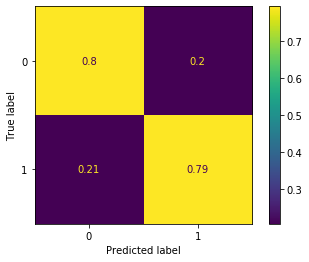

In [54]:
plot_confusion_matrix(clf, x_test, y_test, normalize='true')

LogisticRegression: ROC AUC=0.864


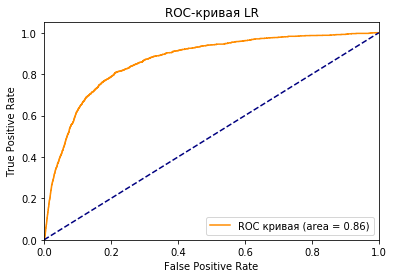

In [55]:
lr_probs = clf.predict_proba(x_test)[:, 1]
testy = y_test

lr_auc = roc_auc_score(testy, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))

# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(testy, lr_probs)
roc_auc = auc(fpr, tpr)

# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая LR')
plt.legend(loc="lower right")
plt.show()

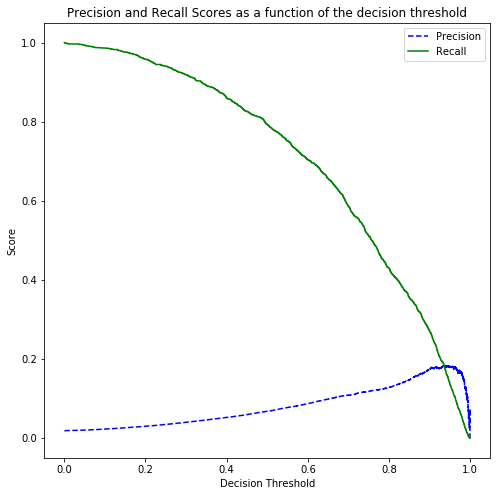

In [56]:
#строим precision-recall кривую
precision, recall, thresholds = precision_recall_curve(testy, lr_probs)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
plot_precision_recall_vs_threshold(precision, recall, thresholds)

In [63]:
lr_probs

array([0.13446949, 0.01851504, 0.05689358, ..., 0.0198408 , 0.74655928,
       0.5255218 ])

              precision    recall  f1-score   support

           0       1.00      0.71      0.83     98832
           1       0.05      0.86      0.10      1850

    accuracy                           0.71    100682
   macro avg       0.52      0.78      0.46    100682
weighted avg       0.98      0.71      0.81    100682



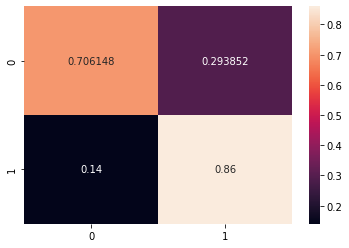

In [80]:
lr_probs = clf.predict_proba(x_test)[:, 1]



tresh = 0.4
preds_tresh = [1 if x > tresh else 0 for x in lr_probs]

print(classification_report(y_test, preds_tresh))

matrix = confusion_matrix(y_test, preds_tresh, normalize='true')
ax = plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax)

## Выводы

В зависимости от выбранного порога можно регулировать precision и recall по классу 1<br>
Таким образом можно менять результаты работы в зависимости от того, что важнее заказчику:<br>
    - получить все дубли и дополнительно ошибочные пары<br>
    - получить только дубли, но с высокой вероятностью пропустить какие-то пары